# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random


import time

start=time.time() # to find runtime

import warnings

#suppress warnings like RunTime error
warnings.filterwarnings('ignore')

# fixing random seed for reproducibility
random.seed(210116270)
np.random.seed(210116270)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_set = pd.read_csv("data_sentiment/train.csv", header=None)
test_set = pd.read_csv("data_sentiment/test.csv", header=None)
dev_set = pd.read_csv("data_sentiment/dev.csv", header=None)

If you use Pandas you can see a sample of the data.

In [3]:
train_set.iloc[0:10,0]

0    note : some may consider portions of the follo...
1    note : some may consider portions of the follo...
2    every once in a while you see a film that is s...
3    when i was growing up in 1970s , boys in my sc...
4    the muppet movie is the first , and the best m...
5    do film critics have morals ?  are there any u...
6    almost a full decade before steven spielberg's...
7    the premise of wag the dog is so simple that i...
8    if you're the type of person who goes on the s...
9    plot : derek zoolander is a male model .  he i...
Name: 0, dtype: object

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
train_set_list=list(train_set.iloc[:,0])
test_set_list=list(test_set.iloc[:,0])
dev_set_list=list(dev_set.iloc[:,0])

train_labels=np.array(train_set.iloc[:,1])
test_labels=np.array(test_set.iloc[:,1])
dev_labels=np.array(dev_set.iloc[:,1])

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,2), token_pattern='[A-Za-z0-9\']+(?:\`[A-Za-z]+)?', 
                   stop_words=[], vocab=set(), char_ngrams=False):
    x_raw=x_raw.lower()
    x=[]
    start= ngram_range[0]
    end= ngram_range[1]
    if char_ngrams==True:
        split_text=(x_raw.split()) 
        filtered_text= [word for word in (split_text) if not word in stop_words]
        sentence=list((' '.join(filtered_text)))
        for n in range(start,end+1):
            char_n_gram= ["".join(j) for j in zip(*[sentence[i:] for i in range(n)])]
            x.append(char_n_gram)
    else:   
        split_text=re.findall(token_pattern,x_raw)  # finds all words and number and combination and excludes special signs
        unigrams = [word for word in split_text if not word in stop_words]    # remove stopwords
        
        for n in range(start,end+1):  # calculate n grams
            if n==1:
                x.append(unigrams)
            if n>1:    # depending on choice of n, ngrams are created
                ngrams=[]
                n_grams= [unigrams[i:i+n] for i in range(len(unigrams)-n+1)]   # picks sequence of words
                for i in range(len(n_grams)): 
                    ngrams.append(' '.join(n_grams[i])) # joins into a sentence e.g. ['natural','language'] to ['natural language']
                x.append(ngrams)   # add to main list with all ngrams
    x = [item for sub_list in x for item in sub_list]    # unlist items and make a single list
    return x
(extract_ngrams(train_set_list[0], stop_words=stop_words, token_pattern= r'\b[A-Za-z][A-Za-z]+\b'))[1000:1030]

['makes little',
 'little mermaid',
 'mermaid so',
 'so affecting',
 'affecting so',
 'so emotionally',
 'emotionally resonant',
 'resonant richness',
 'richness charm',
 'charm characters',
 'characters sheer',
 'sheer clarity',
 'clarity honest',
 'honest simplicity',
 'simplicity their',
 'their emotions',
 'emotions moment',
 'moment mermaid',
 'mermaid ariel',
 'ariel lays',
 'lays eyes',
 'eyes prince',
 'prince eric',
 'eric resolutely',
 'resolutely smitten',
 'smitten such',
 'such pure',
 'pure endearing',
 'endearing character',
 'character one']

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [7]:
extract_ngrams("movie", 
               ngram_range=(2,4), 
               stop_words=stop_words,
               char_ngrams=True)

['mo', 'ov', 'vi', 'ie', 'mov', 'ovi', 'vie', 'movi', 'ovie']

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [8]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'', 
              min_df=0, keep_topN=0, 
              stop_words=[],char_ngrams=False):
    df=dict()
    ngram_counts=dict()
    for i in range(len(X_raw)):
        if char_ngrams==True: 
            ngrams_list = extract_ngrams(X_raw[i], ngram_range=ngram_range, stop_words=stop_words, char_ngrams=True)
        else:
            ngrams_list = extract_ngrams(X_raw[i], ngram_range=ngram_range, stop_words=stop_words, token_pattern=token_pattern)
        
        # seperate all elements by "," so that we get individual elements to be Counted
        ngram_freq_dict= dict(Counter(word for ngram in ngrams_list for word in ngram.split(",")))
        
        for word in ngram_freq_dict.keys():    # calculate ngram counts
            if word not in ngram_counts: ngram_counts[word]=ngram_freq_dict[word]
            else: ngram_counts[word]+=ngram_freq_dict[word]
            
        for word in set(ngrams_list):  # calculate document frequency of words
            if word in df: df[word]+=1
            else: df[word]=1
            
    for word in list(df.keys()):  # delete words which dont occur often in corpus
        if df[word]<min_df:
            del df[word]
            
    if keep_topN>0 and keep_topN<len(df.keys()): # if keep top N grams is required
        sorted_df_dict=dict(sorted(df.items(), key=lambda item: item[1], reverse=True))
        words_to_remove= list(sorted_df_dict)[keep_topN:]
        for w in words_to_remove: del df[w]

    # to remove words not in df but in ngram_counts
    extra_words = [word for word in ngram_counts if not word in df.keys()] 
    for word in extra_words: del ngram_counts[word]
    
    vocab=sorted(list(ngram_counts.keys())) # we make our vocab sorted in alphabetical order
    
    return vocab, df, ngram_counts

In [9]:
range_for_BOW=(1,3)
range_for_BOCN=(2,5)
tp_for_BOW= '[A-Za-z0-9\']+(?:\`[A-Za-z]+)?'

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
s1=time.time()
vocabulary, doc_freq, ngram_counts = get_vocab(train_set_list,min_df=20,stop_words=stop_words, 
                                              ngram_range=range_for_BOW, token_pattern=tp_for_BOW)
vocab_char, df_char, ngram_count_char = get_vocab(train_set_list,min_df=140, char_ngrams=True, 
                                                 ngram_range=range_for_BOCN, stop_words=stop_words)
s2=time.time()

n=random.randint(0,len(vocabulary))
m=random.randint(0,len(vocab_char))
print("Random 10 elements of BOW vocabulary are:",({k:v for (k,v) in [x for x in ngram_counts.items()][n:n+10]}))
print("Random 10 elements of BOCN vocabulary are:",({k:v for (k,v) in [x for x in ngram_count_char.items()][m:m+10]}))

Random 10 elements of BOW vocabulary are: {'devoted': 24, 'whom': 142, "weren't": 52, 'carries': 38, 'message': 126, 'support': 51, 'fellow': 70, 'unfortunately': 270, 'rest': 300, 'appealing': 64}
Random 10 elements of BOCN vocabulary are: {'icat': 359, 'cati': 273, 'ston': 305, 'ompl': 856, 'yste': 379, 'm ( ': 195, ' ( b': 418, 'esid': 210, ' dou': 431, 'doub': 288}


Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [11]:
print("Time taken to get vocabulary=", s2-s1)
print("The lenght of BOW vocabulary is {} and BOCN vocabulary is {}".format(len(vocabulary), len(vocab_char)))
id2word=enumerate(vocabulary+vocab_char)
id_word_dict=dict(id2word)
word_id_dict=dict((word,ID) for ID,word in id_word_dict.items())

Time taken to get vocabulary= 24.363823890686035
The lenght of BOW vocabulary is 4555 and BOCN vocabulary is 12538


Now you should be able to extract n-grams for each text in the training, development and test sets:

In [12]:
train_ngram_doc=[None]*len(train_set_list) # Creating an empty list to store extracted ngrams
train_char_doc=[None]*len(train_set_list)
for i in range(len(train_set_list)): 
    train_ngram_doc[i]=extract_ngrams(train_set_list[i], stop_words=stop_words, 
                                      token_pattern=tp_for_BOW, ngram_range=range_for_BOW)
    train_char_doc[i]=extract_ngrams(train_set_list[i], char_ngrams=True, stop_words=stop_words, 
                                     ngram_range=range_for_BOCN)

In [13]:
test_ngram_doc=[None]*len(test_set_list)
test_char_doc=[None]*len(test_set_list)
for i in range(len(test_set_list)):
    test_ngram_doc[i]=extract_ngrams(test_set_list[i], stop_words=stop_words, 
                                     token_pattern=tp_for_BOW, ngram_range=range_for_BOW)
    test_char_doc[i]=extract_ngrams(test_set_list[i], char_ngrams=True, stop_words=stop_words, 
                                    ngram_range=range_for_BOCN)

In [14]:
dev_ngram_doc=[None]*len(dev_set_list)
dev_char_doc=[None]*len(dev_set_list)
for i in range(len(dev_set_list)):
    dev_ngram_doc[i]=extract_ngrams(dev_set_list[i], stop_words=stop_words, 
                                    token_pattern=tp_for_BOW, ngram_range=range_for_BOW)
    dev_char_doc[i]=extract_ngrams(dev_set_list[i], char_ngrams=True, stop_words=stop_words, 
                                   ngram_range=range_for_BOCN)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [15]:
bias_control= False # if we want bias as a weight. Default False

def vectorise(X_ngram, vocab, bias= bias_control):
    
    if bias==True:
        X_vec=np.zeros(shape=(len(X_ngram), len(vocab)+1)) 
        X_vec[:,-1]=1   # A column with all 1's to manage bias
        
    else: X_vec=np.zeros(shape=(len(X_ngram), len(vocab)))
    
    for i in range(X_vec.shape[0]):
        row_term_freq=Counter(X_ngram[i])
        for j in range(len(vocab)):
            word= vocab[j]
            if word in row_term_freq: 
                X_vec[i,j] = row_term_freq[word]
                
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [16]:
s3=time.time()
train_BOW_count=vectorise(train_ngram_doc,vocabulary)
test_BOW_count=vectorise(test_ngram_doc,vocabulary)
dev_BOW_count=vectorise(dev_ngram_doc,vocabulary)
train_BOCN_count=vectorise(train_char_doc,vocab_char)
test_BOCN_count=vectorise(test_char_doc,vocab_char)
dev_BOCN_count=vectorise(dev_char_doc,vocab_char)
print("Time taken to vectorise all datasets=", time.time()-s3)

Time taken to vectorise all datasets= 14.667065858840942


#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [17]:
idfs_BOW=[None]*len(vocabulary)                             # List to store IDF values
idfs_BOCN=[None]*len(vocab_char)

for i in range(len(vocabulary)):
    word=vocabulary[i]
    idfs_BOW[i] = np.log10(len(train_set_list)/doc_freq[word])

for i in range(len(vocab_char)):
    word=vocab_char[i]
    idfs_BOCN[i] = np.log10(len(train_set_list)/df_char[word])
    
def compute_tfidf_doc(count_vec,idfs, bias= bias_control):       # A function to create tfidf vectors from count vector
    tfidf_vec=np.zeros_like(count_vec)
    if bias==False: 
        for i in range(tfidf_vec.shape[1]):
            tfidf_vec[:,i]=count_vec[:,i]*idfs[i]                # tfidf value = counts of words in column x IDF
    else: 
        for i in range(tfidf_vec.shape[1]-1):
            tfidf_vec[:,i]=count_vec[:,i]*idfs[i]
        tfidf_vec[:,-1]=1                                        # manage bias
    return tfidf_vec

Then transform your count vectors to tf.idf vectors:

In [18]:
train_BOW_tfidf= compute_tfidf_doc(train_BOW_count,idfs_BOW)

test_BOW_tfidf= compute_tfidf_doc(test_BOW_count,idfs_BOW)

dev_BOW_tfidf= compute_tfidf_doc(dev_BOW_count,idfs_BOW)
    
train_BOCN_tfidf= compute_tfidf_doc(train_BOCN_count,idfs_BOCN)

test_BOCN_tfidf= compute_tfidf_doc(test_BOCN_count,idfs_BOCN)

dev_BOCN_tfidf= compute_tfidf_doc(dev_BOCN_count,idfs_BOCN)

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [19]:
def sigmoid(z):
    sig= 1 /(1+ np.exp(-z) )    # 1/(1+e^-z)
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [20]:
def predict_proba(X, weights):
    weights=weights.T                      # To allow matrix multiplication
    preds_proba=sigmoid(np.dot(X,weights))
    return preds_proba    # A value between 0 and 1

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [21]:
def predict_class(X, weights):
    probabilities=predict_proba(X, weights)
    
    preds_class = probabilities.copy()
    for i in range(len(probabilities)):
        prob=probabilities[i]
        if prob>=0.5: preds_class[i]=1 
        else: preds_class[i]=0
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [22]:
def binary_loss(X, Y, weights, alpha=0.00001):
    '''
    Binary Cross-entropy Loss

    X:(len(X),len(vocab))
    Y: array len(Y)
    weights: array len(X)
    '''
    temp_loss=0
    t=1e-08                          # to clip values
    Y_pred=predict_proba(X,weights)
    np.clip(Y_pred,t,1-t,out=Y_pred) # To prevent log(0), we make sure that the values lie between [0.00000001,0.99999999]
    N=len(Y)
    for i in range(N):
        temp_loss= temp_loss - ( Y[i] * np.log(Y_pred[i]) + (1-Y[i]) * np.log(1-Y_pred[i]) )  # -(Y*log(P) + (1-Y)*log(1-P))/N
    weights=np.array(weights)
    weights=weights.flatten()                   # to allow list operation
    l= (temp_loss/N) + alpha*(np.sum(w*w for w in weights))
    
    return l
    

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [23]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=1e-02, 
        alpha=1e-05, epochs=10, 
        tolerance=1e-06, print_progress=False, break_= True):
    weights=np.zeros(shape=(1,X_tr.shape[1]))
    training_loss_history, dev_loss_history=[],[]
    
    for epoch_num in range(epochs):
        np.random.seed(210116270)              # for reproductivity
        p = np.random.permutation(len(Y_tr))   # To shuffle both datasets in a same way
        X=X_tr[p]   # X and Y are new randomised dataset
        Y=Y_tr[p]
        for i in range(len(Y)):                 # we update weight for every datapoint
            X_row= X[i,:]                       # select row
            Y_pred= predict_proba(X_row,weights)
            error= Y_pred - Y[i]                # difference in predicted values
            # w= w - lr * ( ( (y_P-y_i) * X_i ) + 2a*w )
            weights= ((1-2*alpha*lr)*weights) - (lr*error*X_row)        # weight update
            
            # we didn't use matrix multiplication as this multiplication contains array with 1 element. 
            # If it were a bigger matrix, we would have used np.dot
        training_loss_history.append (binary_loss(X_tr,Y_tr,weights,alpha=alpha))
        dev_loss_history.append (binary_loss(X_dev,Y_dev,weights,alpha=alpha))
        
        # printing loss on each epoch
        if print_progress==True:
            print('After epoch {} Training loss is: {} and development loss is: {}'
                  .format(epoch_num+1,training_loss_history[epoch_num],dev_loss_history[epoch_num]))
            
        # terminate run if reach tolerance
        if epoch_num>1 and ((dev_loss_history[epoch_num-1] - dev_loss_history[epoch_num])
                            < tolerance):
            if print_progress==True: 
                print("--------------------------------------------------------------------")
                print("Loop break as threshold reached after {} epochs".format(epoch_num+1))
            if break_== True:      # Default True
                break
            
    return weights, training_loss_history, dev_loss_history

np.set_printoptions(precision=4)  # to print only 4 digits in binary loss
end1=time.time()
print("Time taken to run notebook excluding hyperparameter tuning: {:.3f} seconds".format(end1-start))

Time taken to run notebook excluding hyperparameter tuning: 55.521 seconds


## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [24]:
lr_options=np.logspace(start=-3.5,stop=-2.5,num=4)
l2_reg_strenght=np.logspace(start=-1,stop=-4,num=4)
scores_matrix1= np.empty(shape=(len(lr_options)*len(l2_reg_strenght), 4)) # A matrix to store info for each option
index=0 # index for above matrix
for i in lr_options:
    for j in l2_reg_strenght:
        w,tl,dl= SGD(train_BOW_count,train_labels,dev_BOW_count,dev_labels, lr=i, alpha=j)
        f1_measure= f1_score(dev_labels,predict_class(dev_BOW_count, w))
        scores_matrix1[index,:]=dl[-1], f1_measure,i,j   # f1_measure
        index+= 1
        
best_params=scores_matrix1[np.argmin(scores_matrix1,axis=0)[0]]    # lowest BCE loss score in all scores calculated
least_BCEL1 = best_params[0]                                     #lowest BCE loss on development set
best_lr1= best_params[2]                                    #best learning rate
best_reg1= best_params[3]                                    #best regularization param

print('The best parameters for Binary Cross Entropy loss {:.3f} computed over development data is, lr={}, rp={}'
      .format(least_BCEL1,(best_lr1),best_reg1))

The best parameters for Binary Cross Entropy loss 0.374 computed over development data is, lr=0.0014677992676220691, rp=0.0001


In [25]:
print("The matrix is-") 
pd.DataFrame(scores_matrix1, columns = ['Dev_loss','F1_score', 'LR', 'Reg_strenght'])

The matrix is-


,Dev_loss,F1_score,LR,Reg_strenght
0,0.537761,0.830000,0.000316,0.1000
1,0.446031,0.835821,0.000316,0.0100
2,0.430602,0.840000,0.000316,0.0010
3,0.428966,0.840000,0.000316,0.0001
4,0.545413,0.824742,0.000681,0.1000
5,0.425265,0.861386,0.000681,0.0100
6,0.393913,0.861386,0.000681,0.0010
7,0.390354,0.861386,0.000681,0.0001
8,0.564979,0.793478,0.001468,0.1000
9,0.428823,0.851485,0.001468,0.0100


In [26]:
w_count_BOW, train_losses1, dev_losses1=SGD(train_BOW_count,train_labels,dev_BOW_count,
                                            dev_labels, lr=best_lr1, alpha=best_reg1, print_progress=True)
print("Accuracy score on train data is-",accuracy_score(train_labels,predict_class(train_BOW_count, w_count_BOW))*100)

After epoch 1 Training loss is: [0.3911] and development loss is: [0.4982]
After epoch 2 Training loss is: [0.2997] and development loss is: [0.4396]
After epoch 3 Training loss is: [0.2506] and development loss is: [0.4136]
After epoch 4 Training loss is: [0.2178] and development loss is: [0.399]
After epoch 5 Training loss is: [0.1938] and development loss is: [0.3899]
After epoch 6 Training loss is: [0.175] and development loss is: [0.3839]
After epoch 7 Training loss is: [0.1599] and development loss is: [0.3798]
After epoch 8 Training loss is: [0.1474] and development loss is: [0.3769]
After epoch 9 Training loss is: [0.1368] and development loss is: [0.3749]
After epoch 10 Training loss is: [0.1278] and development loss is: [0.3736]
Accuracy score on train data is- 99.14285714285714


Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

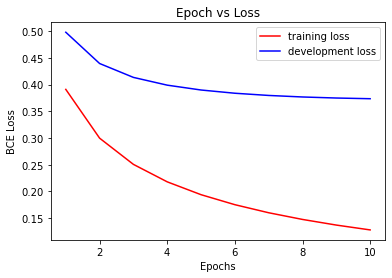

In [27]:
def plot_graph(train_losses,dev_losses):
    epochs_list=list(range(1,len(train_losses)+1,1))
    plt.plot(epochs_list, train_losses,'r-', label='training loss')
    plt.plot(epochs_list, dev_losses,'b', label='development loss')
    plt.xlabel("Epochs")
    plt.ylabel("BCE Loss") 
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.show()

plot_graph(train_losses1,dev_losses1)

Explain here...

As per the plot of training and develpoment losses history above, it can be noted that the loss after 4 epochs for trainset is a lot lower than devset. Because the loss for training set is lower than that of losses of developement set, we say that the model is overfitting as the learned parameters are favouring training data. If the development loss was nearly equal to training loss, the model would have been a good fit. Also, the accuracy score of the model on train data is 99% while on development data, its around 87%, so we can say that the model is overfitting.

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [28]:
def compute_scores(test_data,w):
    predicted = predict_class(test_data, w)
    a=accuracy_score(test_labels,predicted)*100
    p=precision_score(test_labels,predicted)
    r=recall_score(test_labels,predicted)
    f=f1_score(test_labels,predicted)
    return a,p,r,f
scores= np.zeros(shape=(5,4))
preds_te_count = predict_class(test_BOW_count, w_count_BOW)

print('Accuracy %:', accuracy_score(test_labels,preds_te_count)*100)
print('Precision:', precision_score(test_labels,preds_te_count))
print('Recall:', recall_score(test_labels,preds_te_count))
print('F1-Score:', f1_score(test_labels,preds_te_count))
scores[0,:]=compute_scores(test_BOW_count,w_count_BOW)

Accuracy %: 84.25
Precision: 0.8309178743961353
Recall: 0.86
F1-Score: 0.8452088452088452


Finally, print the top-10 words for the negative and positive class respectively.

In [29]:
top_neg = w_count_BOW.argsort() 
print('Top 10 negative words are-')
for i in top_neg[0][:10]:
    print(vocabulary[i])

Top 10 negative words are-
bad
unfortunately
worst
script
boring
only
nothing
why
looks
any


In [30]:
top_pos = (-w_count_BOW).argsort() 
print('Top 10 positive words are-')
for i in top_pos[0][:10]:
    print(vocabulary[i])

Top 10 positive words are-
great
well
seen
fun
world
life
movies
both
quite
also


### Q- If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

If the above classifier is used for some other domain like electronic gadget reviews or restaurant reviews, it might help in classifying reviews purely based on sentiment words like good,great,bad,worst etc. 

But the classifier would not work well in the domains beyond that because each domain has other specific sentiment terms. For exampls, in laptop reviews, the terms like cheap price, big screen, long battery, useless touchpad, bulky weight, loud speaker, bright screen etc can't be picked up by the above classifier. 

For restaurant reviews, the words like airy atmosphere, tasty food, affordable, quick service, accessible location, delicious food, wait time, small quantity etc convey sentiment but our movie review classifier will not work well on the these terms. 

The common sentiments words like great, good, best, beautiful,incredible, bad, poor, unfortunately, worst, not good etc would be present in all the domains regardless of classifiers used and hence can help a bit in sentiment analysis.

### Q- Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

At first, a wide range of values were chosen(1x10^-9 to 0.1) for both learning rate and regularisation strenght. Based on initial runs, the sweet spot was noted and the range of values were toned down narrowly such that the computation time remained low. The number of epochs for hyperparamter tuning was kept the same at 10 epochs.

Fow few models, the selection of hyperparameters was made using the lowest binary loss in last epoch. Later the best learning rate and regularisation strenght were chosen from possible values and the model was again trained to print the progress and find the weights.

The learning rate and number of epochs are inversly proportional i.e, a low learning rate means that the model is making smaller steps towards the minimum and hence, more epochs are needed. Whereas if learning rate is high, the model makes bigger strides towards the minimum and hence fewer epochs are needed. But higher learning rate also means that the model might skip the minimum and start to perform worse. We can see this from the plot below where the learning rate and regularisation strenght were kept constant and the number of epochs were varied. The values were computed after taking average of all development losses in each epoch case to plot the graph. It can be seen that a learning rate which is 10 times more than the other, and produces lowest loss quickly while the lower learning rate model took more epochs to get same loss. Also, a higher learning rate meant that the model went beyond the minimum value of loss and now started to work poorly as seen by increasing of loss and decreasing of accuracy after around 12 epochs, whereas for lower learning rate model, the minimum is reached very slowly and the accuracy gradually improves

Regularisation strength controls how much the model is able to learn. It penalises high values of w hence making sure that the system doesn't overfit. If the regularisation strenght was zero, the model will overfit and give 100% accuracy on training data and won't work well on new data. Fow few models like the BOCN-count, it can be seen that the model is trying to have the least regularisation possible. When the regularisation strenght was put at 0, the system gave better results(86% accuracy on test set). It can hence be said that not all models give an improvement on new data if regularisation is used.

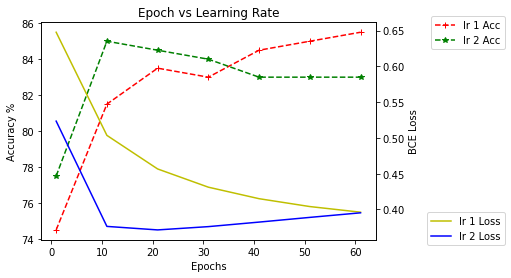

In [31]:
# Here we dont break the function after reaching minimum Loss to show the worsening of model
lr_fixed1=1e-04
lr_fixed2=1e-03
acc_score_list1 , acc_score_list2 , loss_score_list1, loss_score_list2= [],[],[],[]
epochs_range=list(range(1,71,10))
for i in epochs_range:
    w_temp1,_,dl1 = SGD(train_BOW_count,train_labels,dev_BOW_count,dev_labels, lr=lr_fixed1, epochs=i, break_=False)
    w_temp2,_,dl2 = SGD(train_BOW_count,train_labels,dev_BOW_count,dev_labels, lr=lr_fixed2, epochs=i, break_=False)
    acc_score_list1.append(accuracy_score(dev_labels,predict_class(dev_BOW_count, w_temp1))*100)
    acc_score_list2.append(accuracy_score(dev_labels,predict_class(dev_BOW_count, w_temp2))*100)
    loss_score_list1.append(dl1[-1])
    loss_score_list2.append(dl2[-1])
    
fig1 = plt.figure()                # Make a figure
ax1 = fig1.add_subplot()           # Add the new axis
ax1.plot(epochs_range,acc_score_list1,'--r+', label='lr 1 Acc')
ax1.plot(epochs_range,acc_score_list2,'--g*', label='lr 2 Acc')
ax1.legend(bbox_to_anchor=(1.4, 1.05)) # move legend
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
ax2 = ax1.twinx()                  # new Y axis
ax2.plot(epochs_range,loss_score_list1,'y', label='lr 1 Loss')
ax2.plot(epochs_range,loss_score_list2,'b-', label='lr 2 Loss')
plt.ylabel("BCE Loss")
plt.legend(bbox_to_anchor=(1.4, 0.15))
plt.title("Epoch vs Learning Rate")
plt.show()

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

In [32]:
lr_options=np.logspace(start=-2.5,stop=-1.5,num=4)
l2_reg_strenght=np.logspace(start=-1,stop=-4,num=4)
scores_matrix2= np.empty(shape=(len(lr_options)*len(l2_reg_strenght), 4)) 
index=0
for i in lr_options:
    for j in l2_reg_strenght:
        w,tl,dl=SGD(train_BOW_tfidf,train_labels,dev_BOW_tfidf,dev_labels, lr=i, alpha=j)
        f1_measure= f1_score(dev_labels,predict_class(dev_BOW_tfidf, w))
        scores_matrix2[index,:]=dl[-1], f1_measure,i,j
        index+=1
        
best_params=scores_matrix2[np.argmin(scores_matrix2,axis=0)[0]]    # lowest BCE loss score in all scores calculated
least_BCEL2 = best_params[0]                                     #lowest BCE loss on development set
best_lr2= best_params[2]                                    #best learning rate
best_reg2= best_params[3]                                    #best regularization param

print('The best parameters for Binary Cross Entropy loss {:.3f} computed over development data is, lr={:.5f}, rp={}'
      .format(least_BCEL2,(best_lr2),best_reg2))

The best parameters for Binary Cross Entropy loss 0.358 computed over development data is, lr=0.00316, rp=0.0001


In [33]:
print("The matrix is-") 
pd.DataFrame(scores_matrix2, columns = ['Dev_loss','F1_score', 'LR', 'Reg_strenght'])

The matrix is-


,Dev_loss,F1_score,LR,Reg_strenght
0,0.629621,0.817204,0.003162,0.1000
1,0.442589,0.850242,0.003162,0.0100
2,0.371770,0.851675,0.003162,0.0010
3,0.358086,0.855769,0.003162,0.0001
4,0.770294,0.675159,0.006813,0.1000
5,0.459021,0.852941,0.006813,0.0100
6,0.376119,0.865385,0.006813,0.0010
7,0.362853,0.861244,0.006813,0.0001
8,1.315418,0.349206,0.014678,0.1000
9,0.491463,0.830000,0.014678,0.0100


After epoch 1 Training loss is: [0.2743] and development loss is: [0.4605]
After epoch 2 Training loss is: [0.1736] and development loss is: [0.3992]
After epoch 3 Training loss is: [0.1337] and development loss is: [0.381]
After epoch 4 Training loss is: [0.1095] and development loss is: [0.3716]
After epoch 5 Training loss is: [0.0929] and development loss is: [0.366]
After epoch 6 Training loss is: [0.0809] and development loss is: [0.3626]
After epoch 7 Training loss is: [0.0717] and development loss is: [0.3604]
After epoch 8 Training loss is: [0.0645] and development loss is: [0.3591]
After epoch 9 Training loss is: [0.0586] and development loss is: [0.3584]
After epoch 10 Training loss is: [0.0538] and development loss is: [0.3581]


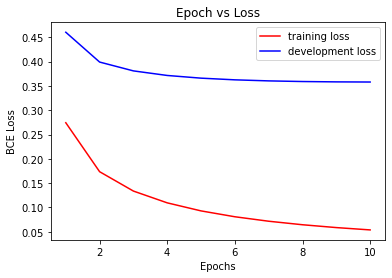

In [34]:
w_tfidf_BOW,train_losses2,dev_losses2=SGD(train_BOW_tfidf,train_labels,dev_BOW_tfidf,dev_labels, 
                                          lr=best_lr2, alpha= best_reg2, print_progress=True)
plot_graph(train_losses2,dev_losses2)

In [35]:
preds_te_tfidf = predict_class(test_BOW_tfidf, w_tfidf_BOW)

print('Accuracy %:', accuracy_score(test_labels,preds_te_tfidf)*100)
print('Precision:', precision_score(test_labels,preds_te_tfidf))
print('Recall:', recall_score(test_labels,preds_te_tfidf))
print('F1-Score:', f1_score(test_labels,preds_te_tfidf))
scores[1,:]=compute_scores(test_BOW_tfidf,w_tfidf_BOW)

Accuracy %: 85.5
Precision: 0.8413461538461539
Recall: 0.875
F1-Score: 0.857843137254902


In [36]:
top_neg = w_tfidf_BOW.argsort() 
print('Top 10 negative words are-')
for i in top_neg[0][:10]:
    print(vocabulary[i])
print("------")
top_pos = (-w_tfidf_BOW).argsort() 
print('Top 10 positive words are-')
for i in top_pos[0][:10]:
    print(vocabulary[i])

Top 10 negative words are-
bad
worst
boring
unfortunately
supposed
awful
why
waste
nothing
poor
------
Top 10 positive words are-
great
hilarious
terrific
fun
perfectly
seen
simple
overall
memorable
life


## BOCN count

In [37]:
lr_options=np.logspace(start=-5,stop=-4,num=4)
l2_reg_strenght=np.logspace(start=-1,stop=-4,num=4)
scores_matrix3= np.empty(shape=(len(lr_options)*len(l2_reg_strenght), 4)) 
index=0
for i in lr_options:
    for j in l2_reg_strenght:
        w,tl,dl=SGD(train_BOCN_count,train_labels,dev_BOCN_count,dev_labels, lr=i, alpha=j)
        f1_measure= f1_score(dev_labels,predict_class(dev_BOCN_count,weights=w))
        scores_matrix3[index,:]=dl[-1], f1_measure,i,j
        index+=1
        
best_params=scores_matrix3[np.argmin(scores_matrix3,axis=0)[0]]    # lowest BCE loss score in all scores calculated
least_BCEL3 = best_params[0]                                     #lowest BCE loss on development set
best_lr3= best_params[2]                                    #best learning rate
best_reg3= best_params[3]                                    #best regularization param

print('The best parameters for Binary Cross Entropy loss {:.3f} computed over development data is, lr={}, rp={}'
      .format(least_BCEL3,(best_lr3),best_reg3))

The best parameters for Binary Cross Entropy loss 0.459 computed over development data is, lr=2.1544346900318823e-05, rp=0.0001


In [38]:
print("The matrix is-") 
pd.DataFrame(scores_matrix3, columns = ['Dev_loss','F1_score', 'LR', 'Reg_strenght'])

The matrix is-


,Dev_loss,F1_score,LR,Reg_strenght
0,0.491936,0.776119,0.000010,0.1000
1,0.487489,0.776119,0.000010,0.0100
2,0.487036,0.776119,0.000010,0.0010
3,0.486991,0.776119,0.000010,0.0001
4,0.469392,0.771429,0.000022,0.1000
5,0.459655,0.771429,0.000022,0.0100
6,0.458637,0.771429,0.000022,0.0010
7,0.458535,0.771429,0.000022,0.0001
8,0.491634,0.772093,0.000046,0.1000
9,0.470386,0.768519,0.000046,0.0100


After epoch 1 Training loss is: [0.5264] and development loss is: [0.5843]
After epoch 2 Training loss is: [0.4395] and development loss is: [0.5263]
After epoch 3 Training loss is: [0.3932] and development loss is: [0.5037]
After epoch 4 Training loss is: [0.3612] and development loss is: [0.4908]
After epoch 5 Training loss is: [0.3365] and development loss is: [0.482]
After epoch 6 Training loss is: [0.3165] and development loss is: [0.4753]
After epoch 7 Training loss is: [0.2996] and development loss is: [0.47]
After epoch 8 Training loss is: [0.2851] and development loss is: [0.4655]
After epoch 9 Training loss is: [0.2724] and development loss is: [0.4618]
After epoch 10 Training loss is: [0.261] and development loss is: [0.4585]


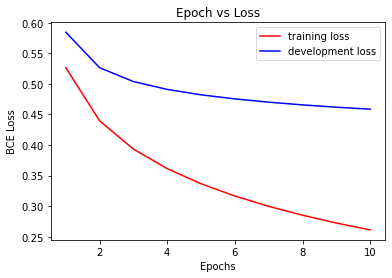

In [39]:
w_count_BOCN,train_losses3,dev_losses3=SGD(train_BOCN_count,train_labels,dev_BOCN_count,dev_labels,
                                           lr=best_lr3, alpha= best_reg3, print_progress=True)
plot_graph(train_losses3,dev_losses3)

In [40]:
preds_count_BOCN = predict_class(test_BOCN_count, w_count_BOCN)

print('Accuracy %:', accuracy_score(test_labels,preds_count_BOCN)*100)
print('Precision:', precision_score(test_labels,preds_count_BOCN))
print('Recall:', recall_score(test_labels,preds_count_BOCN))
print('F1-Score:', f1_score(test_labels,preds_count_BOCN))
scores[2,:]=compute_scores(test_BOCN_count,w_count_BOCN)

Accuracy %: 82.0
Precision: 0.8018867924528302
Recall: 0.85
F1-Score: 0.8252427184466019


In [41]:
top_neg = w_count_BOCN.argsort() 
print('Top 10 negative words are-')
for i in top_neg[0][:10]:
    print(vocab_char[i])
print("------------")
top_pos = (-w_count_BOCN).argsort() 
print('Top 10 positive words are-')
for i in top_pos[0][:10]:
    print(vocab_char[i])

Top 10 negative words are-
ba
he
bad
ad
 bad
ch
in
un
 ba
bad 
------------
Top 10 positive words are-
el
al
tr
 pe
 al
fe
gr
 f
erf
rt


## BOCN tfidf

In [42]:
lr_options=np.logspace(start=-2.5,stop=-3.5,num=4)
l2_reg_strenght=np.logspace(start=-1,stop=-4,num=4)
scores_matrix4= np.empty(shape=(len(lr_options)*len(l2_reg_strenght), 4)) 
index=0
for i in lr_options:
    for j in l2_reg_strenght:
        w,tl,dl=SGD(train_BOCN_tfidf,train_labels,dev_BOCN_tfidf,dev_labels, lr=i, alpha=j)
        f1_measure= f1_score(dev_labels,predict_class(dev_BOCN_tfidf, w))
        scores_matrix4[index,:]=dl[-1], f1_measure,i,j
        index+=1
        
best_params=scores_matrix4[np.argmin(scores_matrix4,axis=0)[0]]    # lowest BCE loss score in all scores calculated
least_BCEL4 = best_params[0]                                     #lowest BCE loss on development set
best_lr4= best_params[2]                                    #best learning rate
best_reg4= best_params[3]                                    #best regularization param

print('The best parameters for Binary Cross Entropy loss {:.3f} computed over development data is, lr={}, rp={}'
      .format(least_BCEL4,(best_lr4),best_reg4))

The best parameters for Binary Cross Entropy loss 0.371 computed over development data is, lr=0.0006812920690579615, rp=0.0001


In [43]:
print("The matrix is-") 
pd.DataFrame(scores_matrix4, columns = ['Dev_loss','F1_score', 'LR', 'Reg_strenght'])

The matrix is-


,Dev_loss,F1_score,LR,Reg_strenght
0,0.608111,0.779487,0.003162,0.1000
1,0.455997,0.844221,0.003162,0.0100
2,0.438712,0.831683,0.003162,0.0010
3,0.434388,0.831683,0.003162,0.0001
4,0.527115,0.797927,0.001468,0.1000
5,0.410394,0.832487,0.001468,0.0100
6,0.385068,0.832487,0.001468,0.0010
7,0.382199,0.828283,0.001468,0.0001
8,0.487637,0.828283,0.000681,0.1000
9,0.392314,0.833333,0.000681,0.0100


After epoch 1 Training loss is: [0.2989] and development loss is: [0.4543]
After epoch 2 Training loss is: [0.2103] and development loss is: [0.4045]
After epoch 3 Training loss is: [0.1651] and development loss is: [0.3852]
After epoch 4 Training loss is: [0.1366] and development loss is: [0.3762]
After epoch 5 Training loss is: [0.1167] and development loss is: [0.3719]
After epoch 6 Training loss is: [0.1021] and development loss is: [0.3702]
After epoch 7 Training loss is: [0.0908] and development loss is: [0.37]
After epoch 8 Training loss is: [0.0818] and development loss is: [0.3706]
--------------------------------------------------------------------
Loop break as threshold reached after 8 epochs


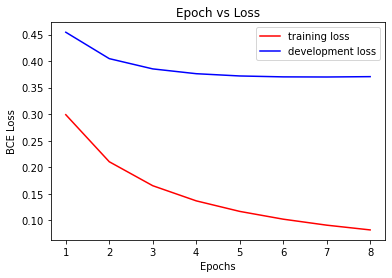

In [44]:
w_BOCN_tfidf,train_losses4,dev_losses4=SGD(train_BOCN_tfidf,train_labels,dev_BOCN_tfidf,dev_labels, 
                                           lr=best_lr4, alpha= best_reg4, print_progress=True)
plot_graph(train_losses4,dev_losses4)

In [45]:
preds_BOCN_tfidf = predict_class(test_BOCN_tfidf, w_BOCN_tfidf)

print('Accuracy %:', accuracy_score(test_labels,preds_BOCN_tfidf)*100)
print('Precision:', precision_score(test_labels,preds_BOCN_tfidf))
print('Recall:', recall_score(test_labels,preds_BOCN_tfidf))
print('F1-Score:', f1_score(test_labels,preds_BOCN_tfidf))
scores[3,:]=compute_scores(test_BOCN_tfidf,w_BOCN_tfidf)

Accuracy %: 86.0
Precision: 0.839622641509434
Recall: 0.89
F1-Score: 0.8640776699029127


In [46]:
top_neg = w_BOCN_tfidf.argsort() 
print('Top 10 negative words are-')
for i in top_neg[0][:10]:
    print(vocab_char[i])
print("------------")
top_pos = (-w_BOCN_tfidf).argsort() 
print('Top 10 positive words are-')
for i in top_pos[0][:10]:
    print(vocab_char[i])

Top 10 negative words are-
bad
 bad
bad 
 bad 
 wors
wors
4 
 wast
waste
uppos
------------
Top 10 positive words are-
grea
 grea
mpi
rifi
great
hilar
an's
an's 
ilar
hila


## BOW+BOCN tfidf

In [47]:
#We use tfidf weighting schemes as they gave the best accuracy in both the instances
train_BOW_BOCN=np.hstack((train_BOW_tfidf,train_BOCN_tfidf))
dev_BOW_BOCN=np.hstack((dev_BOW_tfidf,dev_BOCN_tfidf))
test_BOW_BOCN=np.hstack((test_BOW_tfidf,test_BOCN_tfidf))

if bias_control==True: # delete 1 extra column of 1s as both datasets have one each
    train_BOW_BOCN=np.delete(train_BOW_BOCN, len(vocabulary)+1, axis=1)
    test_BOW_BOCN=np.delete(test_BOW_BOCN, len(vocabulary)+1, axis=1)
    dev_BOW_BOCN=np.delete(dev_BOW_BOCN, len(vocabulary)+1, axis=1)
print(train_BOW_BOCN.shape)

(1400, 17093)


In [48]:
lr_options=np.logspace(start=-4,stop=-1,num=4)
l2_reg_strenght=np.logspace(start=-1,stop=-4,num=4)
scores_matrix5= np.empty(shape=(len(lr_options)*len(l2_reg_strenght), 4)) 
index=0
for i in lr_options:
    for j in l2_reg_strenght:
        w,tl,dl=SGD(train_BOW_BOCN,train_labels,dev_BOW_BOCN,dev_labels, lr=i, alpha=j)
        f1_measure= f1_score(dev_labels,predict_class(dev_BOW_BOCN, w))
        scores_matrix5[index,:]=dl[-1], f1_measure,i,j
        index+=1
        
best_params=scores_matrix5[np.argmin(scores_matrix5,axis=0)[0]]    # lowest BCE loss score in all scores calculated
least_BCEL5= best_params[0]                                     #lowest BCE loss on development set
best_lr5= best_params[2]                                    #best learning rate
best_reg5= best_params[3]                                    #best regularization param

print('The best parameters for Binary Cross Entropy loss {:.3f} computed over development data is, lr={}, rp={}'
      .format(least_BCEL5,(best_lr5),best_reg5))

The best parameters for Binary Cross Entropy loss 0.352 computed over development data is, lr=0.001, rp=0.0001


In [49]:
print("The matrix is-") 
pd.DataFrame(scores_matrix5, columns = ['Dev_loss','F1_score', 'LR', 'Reg_strenght'])

The matrix is-


,Dev_loss,F1_score,LR,Reg_strenght
0,0.463375,0.854460,0.0001,0.1000
1,0.413365,0.854460,0.0001,0.0100
2,0.407361,0.854460,0.0001,0.0010
3,0.406749,0.854460,0.0001,0.0001
4,0.488756,0.836735,0.0010,0.1000
5,0.376892,0.858537,0.0010,0.0100
6,0.355130,0.859903,0.0010,0.0010
7,0.352455,0.859903,0.0010,0.0001
8,5.547654,0.095238,0.0100,0.1000
9,0.440989,0.832487,0.0100,0.0100


After epoch 1 Training loss is: [0.2022] and development loss is: [0.4102]
After epoch 2 Training loss is: [0.129] and development loss is: [0.3703]
After epoch 3 Training loss is: [0.0954] and development loss is: [0.3577]
After epoch 4 Training loss is: [0.0761] and development loss is: [0.353]
After epoch 5 Training loss is: [0.0634] and development loss is: [0.3519]
After epoch 6 Training loss is: [0.0546] and development loss is: [0.3525]
--------------------------------------------------------------------
Loop break as threshold reached after 6 epochs


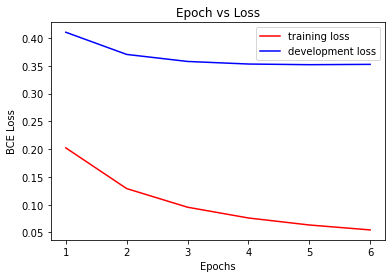

In [50]:
w_BOW_BOCN,train_losses5,dev_losses5=SGD(train_BOW_BOCN,train_labels,dev_BOW_BOCN,dev_labels, lr=best_lr5,
                                         alpha= best_reg5, print_progress=True)
plot_graph(train_losses5,dev_losses5)

In [51]:
preds_BOW_BOCN = predict_class(test_BOW_BOCN, w_BOW_BOCN)

print('Accuracy %:', accuracy_score(test_labels,preds_BOW_BOCN)*100)
print('Precision:', precision_score(test_labels,preds_BOW_BOCN))
print('Recall:', recall_score(test_labels,preds_BOW_BOCN))
print('F1-Score:', f1_score(test_labels,preds_BOW_BOCN))
scores[4,:]=compute_scores(test_BOW_BOCN,w_BOW_BOCN)

Accuracy %: 87.0
Precision: 0.8457943925233645
Recall: 0.905
F1-Score: 0.8743961352657006


In [52]:
top_neg = w_BOW_BOCN.argsort() 
print('Top 10 negative words are-')
for i in top_neg[0][:10]:
    print(id_word_dict[i])
print("------------")
top_pos = (-w_BOW_BOCN).argsort() 
print('Top 10 positive words are-')
for i in top_pos[0][:10]:
    print(id_word_dict[i])

Top 10 negative words are-
bad
 bad
bad
bad 
 bad 
 wors
wors
 wast
4
waste
------------
Top 10 positive words are-
jackie
an's 
an's
grea
 grea
rifi
inger
hilarious
 memo
8




## Full Results



In [53]:
row_names=["BOW-count","BOW-tfidf","BOCN-count","BOCN-tfidf","BOW+BOCN-tfidf"]
column_names=["Accuracy %","Precision","Recall","F1-Score"]
Full_results= pd.DataFrame(scores, index=row_names, columns=column_names)
Full_results

,Accuracy %,Precision,Recall,F1-Score
BOW-count,84.25,0.830918,0.860,0.845209
BOW-tfidf,85.50,0.841346,0.875,0.857843
BOCN-count,82.00,0.801887,0.850,0.825243
BOCN-tfidf,86.00,0.839623,0.890,0.864078
BOW+BOCN-tfidf,87.00,0.845794,0.905,0.874396


My best performing model is the model which has ngrams from both Bag of Words and Bag of Character Ngrams with tfidf weighting scheme.

It is because, we didn't use stemming in the preprocessing steps of this assignment and many terms which had prefixes and suffixes were not represented in the same way as they should have been in Bag of Words models. This meant that counts of words were a bit less than those with stemming. Had these words been included, the BOW_count and BOW_tfidf model would have performed marginally better. But this kind of compromise is not made in BOCN as the words are divided and hence duplicates can be found. But this representation is again bit tedious because of large vocabulary size(many weights to be learnt) and potential misrepresentation of words(Example- "shit" is a word which might mean negative in a movie review, but in BOCN representation, "hit" will be captured in both positive and negative because 'shit' will contain 'hit' too).

So this kind of issue is solved by using combination of both BOW and BOCN, as the frequency will balance the words original representation and hence a higher accuracy and F-1 score.

In [54]:
end2=time.time()
print("Runtime of notebook is:",end2-start)

Runtime of notebook is: 269.0276291370392


In [55]:
from sklearn import svm


In [59]:
clf=svm.SVC(kernel='linear', random_state=42).fit(train_BOW_BOCN,train_labels)
p=clf.predict(test_BOW_BOCN)
accuracy_score(p,test_labels)

0.8475